In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

classes = pickle.load(open('/content/drive/My Drive/for_colab/classes.pkl','rb'))
print(classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


In [4]:
import keras, keras.layers as L
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

model.summary()

Using TensorFlow backend.


96116736/96112376 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________

Функция ниже позволяет найти для заданного изображения топ10 классов по мнению InceptionV3.

In [0]:
from skimage.transform import resize
def predict_top10(img):
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    plt.imshow(img)
    plt.show()

    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    probs = model.predict(img_preprocessed)[0]
    labels = probs.argsort()[-1:-10:-1]

    print('top-10 classes:')
    for l in labels:
        print('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

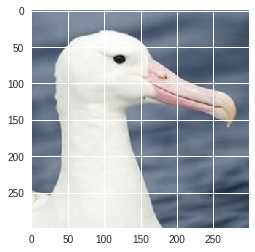

top-10 classes:
0.9129	albatross
0.0018	turnstile
0.0010	drake
0.0006	collie
0.0005	goose
0.0005	hammerhead
0.0005	nipple
0.0005	cello
0.0004	llama


## Dogs Vs Cats

А теперь попробуем построить классификатор, который отличает изображение кошки от собаки. 

Код ниже позволяет вам загрузить данные, необходимые для данного задания.

In [8]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

 inflating: train/dog.10190.jpg     
  inflating: train/dog.10191.jpg     
  inflating: train/dog.10192.jpg     
  inflating: train/dog.10193.jpg     
  inflating: train/dog.10194.jpg     
  inflating: train/dog.10195.jpg     
  inflating: train/dog.10196.jpg     
  inflating: train/dog.10197.jpg     
  inflating: train/dog.10198.jpg     
  inflating: train/dog.10199.jpg     
  inflating: train/dog.102.jpg       
  inflating: train/dog.1020.jpg      
  inflating: train/dog.10200.jpg     
  inflating: train/dog.10201.jpg     
  inflating: train/dog.10202.jpg     
  inflating: train/dog.10203.jpg     
  inflating: train/dog.10204.jpg     
  inflating: train/dog.10205.jpg     
  inflating: train/dog.10206.jpg     
  inflating: train/dog.10207.jpg     
  inflating: train/dog.10208.jpg     
  inflating: train/dog.10209.jpg     
  inflating: train/dog.1021.jpg      
  inflating: train/dog.10210.jpg     
  inflating: train/dog.10211.jpg     
  inflating: train/dog.10212.jpg     
  inflating: 

## Sklearn way

In [0]:
import os
import glob

from tqdm import tqdm


PATH = "./train"

cat_files = glob.glob("./train/cat.*.jpg")
dog_files = glob.glob("./train/dog.*.jpg")

all_files = cat_files + dog_files
all_files_labels = [0] * len(cat_files) + [1] * len(dog_files)
X = np.array(all_files)
y = np.array(all_files_labels)


In [0]:
from skimage.io import imread
import re
import math

class MyGenerator(keras.utils.Sequence):
    def __init__(self, files, batch_size=64):
        self.files = files
        self.len = math.ceil(len(files) * 1. / batch_size)
        self.batch_size = batch_size
    
    def __len__(self):
        return self.len

    def get_input(self, path):
        img = resize(imread(path), (299, 299), mode='reflect')
        return img
  
    def __getitem__(self, index):
        return self.image_generator(self.files, batch_size=self.batch_size)
  
    def get_output(self, path, label_file=None):
        if re.search('cat', path):
            return 0
        else:
            return 1
    
    def image_generator(self, files, label_file=None, batch_size = 64):
        #https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
        while True:
            # Select files (paths/indices) for the batch
            batch_paths = np.random.choice(a = files, 
                                           size = batch_size)
            batch_input = []
            batch_output = [] 

            for input_path in batch_paths:
                input = self.get_input(input_path)
                output = self.get_output(input_path,label_file=label_file )

                batch_input += [ input ]
                batch_output += [ output ]
            # Return a tuple of (input,output) to feed the network
            batch_x = np.array( batch_input )
            batch_y = np.array( batch_output )

            return ( batch_x, batch_y )


Разделим данные на обучение и тест в отношении 4:1.

In [0]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
X_train.shape, X_test.shape

((20000,), (5000,))

Обучим поверх этих признаков классификатор из sklearn (можно попробовать несколько и выбрать лучший)

In [0]:
def get_images(files, start, size):
    images = []
    for i in range(start, start + size):
        images.append(resize(imread(files[i]), (299, 299), mode='reflect'))
    return np.array(images)

In [38]:
from keras.models import Model
from tqdm import tqdm

layer_name = 'avg_pool'
simple_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

X_train_imgs = []
for i in range(0, X_train.shape[0], 1000):
    read = get_images(X_train, i, 1000)
    print('read')
    X_train_imgs.append(simple_model.predict(read))
    
print("now test")
X_test_imgs = []
for i in range(0, X_test.shape[0], 1000):
    read = get_images(X_test, i, 1000)
    print('read')
    X_test_imgs.append(simple_model.predict(read))

X_train_imgs = np.array(X_train_imgs).squeeze()
X_test_imgs = np.array(X_test_imgs).squeeze()

read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
read
now test
read
read
read
read
read


In [0]:
X_train_ap = X_train_imgs.reshape(-1 , 2048)
X_test_ap = X_test_imgs.reshape(-1, 2048)

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_depth=4)
clf.fit(X_train_ap, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
from sklearn.metrics import roc_auc_score

prediction = clf.predict_proba(X_test_ap)
print("ROC-AUC random fores:", roc_auc_score(y_test, prediction[:, 1]))

ROC-AUC random fores: 0.998977707004331


Сверточные нейронные сети (особенно такие глубокие) круто извлекают признаки

## Fine-tuning

In [0]:
def finetune_model(model):
    for layer in model.layers[:len(model.layers)]:
        layer.trainable=False
    
    x = model.layers[-1].output
    x = L.Dense(1024, activation='relu')(x)
    predictions = L.Dense(2, activation='softmax')(x)
    return Model(model.input, predictions)

Построим сеть, в которой InceptionV3 без последних слоев используется в качестве первого слоя. Поверх неё надстройте новые слои

In [0]:
ft_model = finetune_model(model)
ft_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [0]:
generator_train = MyGenerator(X_train)

Добучим последние слои на обучающей выборке, не меняя весов изначальной сети

In [84]:
ft_model.fit_generator(generator_train)

Epoch 1/1
313/313 [==============================] - 551s 2s/step - loss: 0.1894 - acc: 0.9454


In [0]:
ft_model.save('./inception_head')

Можно взять несколько предыдущих слоёв модели и продолжите обучение. На этом этапе важно не переобучиться: смотрите на качество на валидации.

In [0]:
for layer in ft_model.layers[-3:]:
    layer.trainable = True

In [90]:
ft_model.fit_generator(generator_train, epochs=2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/2
313/313 [==============================] - 545s 2s/step - loss: 0.0999 - acc: 0.9645
Epoch 2/2
313/313 [==============================] - 509s 2s/step - loss: 0.0906 - acc: 0.9681


In [69]:
test = get_images(X_test, 0, len(X_test))
predictions = new_model.predict(test)
print(roc_auc_score(y_test, y_scores[:, 1]))

0.999976707043034
